In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Dataset, Data

def build_knn_graph(points, k=8):
    M = points.shape[0]

    dist_matrix = np.zeros((M, M))
    for i in range(M):
        for j in range(i+1, M):
            d_eta = points[i, 0] - points[j, 0]
            d_phi = points[i, 1] - points[j, 1]
            dR = np.sqrt(d_eta**2 + d_phi**2)
            dist_matrix[i, j] = dR
            dist_matrix[j, i] = dR
    
    edges = []
    for i in range(M):
        neighbors = np.argsort(dist_matrix[i])[:k]  
        for nbr in neighbors:
            if nbr != i:
                edges.append([i, nbr])
    edge_index = torch.tensor(edges, dtype=torch.long).t()  # shape (2, E)
    return edge_index

class QGDataset(Dataset):
    def __init__(self, X, y, k=8, transform=None):
        """
        X: shape (N, M, 4)
        y: shape (N,)
        k: k-NN 的 k
        """
        super().__init__(None, transform, None)
        self.X = X
        self.y = y
        self.k = k
    
    def len(self):
        return len(self.X)
    
    def get(self, idx):
        # (shape: (M, 4))
        jet = self.X[idx]
        label = self.y[idx]
        

        x = torch.tensor(jet, dtype=torch.float)  # shape (M, 4)
        

        # jet[:, 1] = eta; jet[:, 2] = phi
        eta_phi = jet[:, 1:3]
        edge_index = build_knn_graph(eta_phi, k=self.k)
        
        y_tensor = torch.tensor([label], dtype=torch.long)
        
        data = Data(x=x, edge_index=edge_index, y=y_tensor)
        return data

from torch_geometric.loader import DataLoader

data = np.load("QG_jets.npz")
X = data["X"]  # shape: (100000, M, 4)
y = data["y"]  # shape: (100000,)

# train / test split
N = len(X)
indices = np.arange(N)
np.random.shuffle(indices)
train_size = int(0.1 * N)
train_idx = indices[:train_size]
test_idx  = indices[train_size:]

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]


train_dataset = QGDataset(X_train, y_train, k=8)
test_dataset  = QGDataset(X_test,  y_test,  k=8)

#  DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [3]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool

# === 1. GCN ===
class GCNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_dim=64, out_dim=2):
        super(GCNClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # global mean pooling
        x = global_mean_pool(x, batch)
        return self.fc(x)

# === 2. GAT ===
class GATClassifier(nn.Module):
    def __init__(self, in_channels, hidden_dim=64, out_dim=2, heads=4):
        super(GATClassifier, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_dim, heads=heads)
        #  output channel = hidden_dim * heads
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads)
        self.fc = nn.Linear(hidden_dim * heads, out_dim)
    
    def forward(self, x, edge_index, batch):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        
        x = global_mean_pool(x, batch)
        return self.fc(x)


In [4]:
def train_one_epoch(model, optimizer, loader, device):
    model.train()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.num_graphs
        
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc

def test(model, loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
        
        total_loss += loss.item() * data.num_graphs
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc


Creating dataset: 100%|██████████| 100000/100000 [03:25<00:00, 486.47it/s]


Training GCN...


Epochs:   2%|▏         | 1/50 [00:45<37:17, 45.65s/it]

Epoch 1/50, Train Loss: 0.6958, Train Acc: 0.5600, Val Loss: 0.6889, Val Acc: 0.5310


Epochs:   4%|▍         | 2/50 [01:11<27:09, 33.95s/it]

Epoch 2/50, Train Loss: 0.6856, Train Acc: 0.5713, Val Loss: 0.6853, Val Acc: 0.5862


Epochs:   6%|▌         | 3/50 [01:34<22:50, 29.15s/it]

Epoch 3/50, Train Loss: 0.6848, Train Acc: 0.5742, Val Loss: 0.6964, Val Acc: 0.5036


Epochs:   8%|▊         | 4/50 [01:59<20:57, 27.33s/it]

Epoch 4/50, Train Loss: 0.6838, Train Acc: 0.5769, Val Loss: 0.6834, Val Acc: 0.5511


Epochs:  10%|█         | 5/50 [02:26<20:23, 27.18s/it]

Epoch 5/50, Train Loss: 0.6766, Train Acc: 0.5891, Val Loss: 0.6665, Val Acc: 0.5737


Epochs:  12%|█▏        | 6/50 [03:11<24:24, 33.29s/it]

Epoch 6/50, Train Loss: 0.6357, Train Acc: 0.6436, Val Loss: 0.6065, Val Acc: 0.6637


Epochs:  14%|█▍        | 7/50 [03:39<22:35, 31.52s/it]

Epoch 7/50, Train Loss: 0.5947, Train Acc: 0.6847, Val Loss: 0.5619, Val Acc: 0.7156


Epochs:  16%|█▌        | 8/50 [04:32<26:49, 38.33s/it]

Epoch 8/50, Train Loss: 0.5710, Train Acc: 0.7035, Val Loss: 0.5570, Val Acc: 0.7057


Epochs:  18%|█▊        | 9/50 [05:37<31:58, 46.79s/it]

Epoch 9/50, Train Loss: 0.5577, Train Acc: 0.7167, Val Loss: 0.5395, Val Acc: 0.7275


Epochs:  20%|██        | 10/50 [06:42<34:54, 52.36s/it]

Epoch 10/50, Train Loss: 0.5469, Train Acc: 0.7269, Val Loss: 0.5261, Val Acc: 0.7400


Epochs:  22%|██▏       | 11/50 [07:46<36:19, 55.89s/it]

Epoch 11/50, Train Loss: 0.5399, Train Acc: 0.7326, Val Loss: 0.5331, Val Acc: 0.7267


Epochs:  24%|██▍       | 12/50 [08:35<34:07, 53.88s/it]

Epoch 12/50, Train Loss: 0.5342, Train Acc: 0.7374, Val Loss: 0.5161, Val Acc: 0.7471


Epochs:  26%|██▌       | 13/50 [08:58<27:23, 44.42s/it]

Epoch 13/50, Train Loss: 0.5325, Train Acc: 0.7368, Val Loss: 0.5068, Val Acc: 0.7572


Epochs:  28%|██▊       | 14/50 [09:23<23:10, 38.61s/it]

Epoch 14/50, Train Loss: 0.5302, Train Acc: 0.7394, Val Loss: 0.5305, Val Acc: 0.7337


Epochs:  30%|███       | 15/50 [09:48<20:05, 34.44s/it]

Epoch 15/50, Train Loss: 0.5294, Train Acc: 0.7405, Val Loss: 0.5192, Val Acc: 0.7414


Epochs:  32%|███▏      | 16/50 [10:32<21:12, 37.42s/it]

Epoch 16/50, Train Loss: 0.5263, Train Acc: 0.7433, Val Loss: 0.5059, Val Acc: 0.7560


Epochs:  34%|███▍      | 17/50 [10:59<18:48, 34.20s/it]

Epoch 17/50, Train Loss: 0.5251, Train Acc: 0.7451, Val Loss: 0.5105, Val Acc: 0.7577


Epochs:  36%|███▌      | 18/50 [11:24<16:49, 31.56s/it]

Epoch 18/50, Train Loss: 0.5239, Train Acc: 0.7441, Val Loss: 0.5023, Val Acc: 0.7621


Epochs:  38%|███▊      | 19/50 [11:54<15:58, 30.92s/it]

Epoch 19/50, Train Loss: 0.5254, Train Acc: 0.7430, Val Loss: 0.5057, Val Acc: 0.7569


Epochs:  40%|████      | 20/50 [12:20<14:43, 29.44s/it]

Epoch 20/50, Train Loss: 0.5216, Train Acc: 0.7463, Val Loss: 0.5186, Val Acc: 0.7407


Epochs:  42%|████▏     | 21/50 [12:45<13:34, 28.09s/it]

Epoch 21/50, Train Loss: 0.5214, Train Acc: 0.7467, Val Loss: 0.5049, Val Acc: 0.7596


Epochs:  44%|████▍     | 22/50 [13:06<12:06, 25.96s/it]

Epoch 22/50, Train Loss: 0.5197, Train Acc: 0.7473, Val Loss: 0.5030, Val Acc: 0.7613


Epochs:  46%|████▌     | 23/50 [13:26<10:57, 24.34s/it]

Epoch 23/50, Train Loss: 0.5204, Train Acc: 0.7486, Val Loss: 0.5010, Val Acc: 0.7612


Epochs:  48%|████▊     | 24/50 [13:46<10:01, 23.12s/it]

Epoch 24/50, Train Loss: 0.5193, Train Acc: 0.7472, Val Loss: 0.5092, Val Acc: 0.7552


Epochs:  50%|█████     | 25/50 [14:07<09:16, 22.27s/it]

Epoch 25/50, Train Loss: 0.5193, Train Acc: 0.7482, Val Loss: 0.4987, Val Acc: 0.7703


Epochs:  52%|█████▏    | 26/50 [14:30<09:01, 22.55s/it]

Epoch 26/50, Train Loss: 0.5184, Train Acc: 0.7491, Val Loss: 0.5041, Val Acc: 0.7538


Epochs:  54%|█████▍    | 27/50 [14:55<08:59, 23.45s/it]

Epoch 27/50, Train Loss: 0.5170, Train Acc: 0.7485, Val Loss: 0.4989, Val Acc: 0.7638


Epochs:  56%|█████▌    | 28/50 [15:19<08:38, 23.57s/it]

Epoch 28/50, Train Loss: 0.5173, Train Acc: 0.7488, Val Loss: 0.5017, Val Acc: 0.7588


Epochs:  58%|█████▊    | 29/50 [15:46<08:34, 24.49s/it]

Epoch 29/50, Train Loss: 0.5160, Train Acc: 0.7518, Val Loss: 0.5034, Val Acc: 0.7547


Epochs:  60%|██████    | 30/50 [16:10<08:09, 24.46s/it]

Epoch 30/50, Train Loss: 0.5165, Train Acc: 0.7503, Val Loss: 0.4960, Val Acc: 0.7680


Epochs:  62%|██████▏   | 31/50 [16:35<07:48, 24.65s/it]

Epoch 31/50, Train Loss: 0.5158, Train Acc: 0.7517, Val Loss: 0.5366, Val Acc: 0.7198


Epochs:  64%|██████▍   | 32/50 [17:01<07:26, 24.80s/it]

Epoch 32/50, Train Loss: 0.5150, Train Acc: 0.7521, Val Loss: 0.5004, Val Acc: 0.7620


Epochs:  66%|██████▌   | 33/50 [17:24<06:54, 24.39s/it]

Epoch 33/50, Train Loss: 0.5141, Train Acc: 0.7521, Val Loss: 0.4991, Val Acc: 0.7636


Epochs:  68%|██████▊   | 34/50 [17:49<06:34, 24.64s/it]

Epoch 34/50, Train Loss: 0.5147, Train Acc: 0.7516, Val Loss: 0.4990, Val Acc: 0.7630


Epochs:  70%|███████   | 35/50 [18:16<06:17, 25.15s/it]

Epoch 35/50, Train Loss: 0.5131, Train Acc: 0.7527, Val Loss: 0.4962, Val Acc: 0.7673


Epochs:  72%|███████▏  | 36/50 [18:38<05:41, 24.38s/it]

Epoch 36/50, Train Loss: 0.5130, Train Acc: 0.7522, Val Loss: 0.5134, Val Acc: 0.7443


Epochs:  74%|███████▍  | 37/50 [19:01<05:10, 23.91s/it]

Epoch 37/50, Train Loss: 0.5118, Train Acc: 0.7542, Val Loss: 0.4983, Val Acc: 0.7623


Epochs:  76%|███████▌  | 38/50 [19:24<04:44, 23.69s/it]

Epoch 38/50, Train Loss: 0.5106, Train Acc: 0.7541, Val Loss: 0.4930, Val Acc: 0.7695


Epochs:  78%|███████▊  | 39/50 [19:47<04:18, 23.46s/it]

Epoch 39/50, Train Loss: 0.5112, Train Acc: 0.7533, Val Loss: 0.5200, Val Acc: 0.7403


Epochs:  80%|████████  | 40/50 [20:07<03:42, 22.27s/it]

Epoch 40/50, Train Loss: 0.5112, Train Acc: 0.7547, Val Loss: 0.5016, Val Acc: 0.7606


Epochs:  82%|████████▏ | 41/50 [20:28<03:18, 22.10s/it]

Epoch 41/50, Train Loss: 0.5097, Train Acc: 0.7566, Val Loss: 0.4957, Val Acc: 0.7667


Epochs:  84%|████████▍ | 42/50 [20:49<02:54, 21.78s/it]

Epoch 42/50, Train Loss: 0.5101, Train Acc: 0.7547, Val Loss: 0.4918, Val Acc: 0.7725


Epochs:  86%|████████▌ | 43/50 [21:10<02:30, 21.52s/it]

Epoch 43/50, Train Loss: 0.5087, Train Acc: 0.7560, Val Loss: 0.4947, Val Acc: 0.7658


Epochs:  88%|████████▊ | 44/50 [21:32<02:08, 21.49s/it]

Epoch 44/50, Train Loss: 0.5076, Train Acc: 0.7561, Val Loss: 0.4932, Val Acc: 0.7696


Epochs:  90%|█████████ | 45/50 [21:53<01:46, 21.36s/it]

Epoch 45/50, Train Loss: 0.5092, Train Acc: 0.7557, Val Loss: 0.4946, Val Acc: 0.7678


Epochs:  92%|█████████▏| 46/50 [22:15<01:26, 21.64s/it]

Epoch 46/50, Train Loss: 0.5089, Train Acc: 0.7571, Val Loss: 0.4910, Val Acc: 0.7697


Epochs:  94%|█████████▍| 47/50 [22:37<01:05, 21.70s/it]

Epoch 47/50, Train Loss: 0.5080, Train Acc: 0.7557, Val Loss: 0.4955, Val Acc: 0.7677


Epochs:  96%|█████████▌| 48/50 [22:57<00:42, 21.31s/it]

Epoch 48/50, Train Loss: 0.5076, Train Acc: 0.7546, Val Loss: 0.4921, Val Acc: 0.7665


Epochs:  98%|█████████▊| 49/50 [23:19<00:21, 21.32s/it]

Epoch 49/50, Train Loss: 0.5052, Train Acc: 0.7569, Val Loss: 0.4917, Val Acc: 0.7692


Epochs: 100%|██████████| 50/50 [23:39<00:00, 28.39s/it]


Epoch 50/50, Train Loss: 0.5078, Train Acc: 0.7569, Val Loss: 0.4924, Val Acc: 0.7708

Training EdgeConv...


Epochs:   2%|▏         | 1/50 [00:36<29:58, 36.70s/it]

Epoch 1/50, Train Loss: 0.6854, Train Acc: 0.5742, Val Loss: 0.6739, Val Acc: 0.6034


Epochs:   4%|▍         | 2/50 [01:18<31:50, 39.81s/it]

Epoch 2/50, Train Loss: 0.6729, Train Acc: 0.6009, Val Loss: 0.6680, Val Acc: 0.6039


Epochs:   6%|▌         | 3/50 [01:59<31:42, 40.47s/it]

Epoch 3/50, Train Loss: 0.6689, Train Acc: 0.6038, Val Loss: 0.6890, Val Acc: 0.5133


Epochs:   8%|▊         | 4/50 [02:40<31:11, 40.68s/it]

Epoch 4/50, Train Loss: 0.6641, Train Acc: 0.6120, Val Loss: 0.6946, Val Acc: 0.5169


Epochs:  10%|█         | 5/50 [03:18<29:46, 39.69s/it]

Epoch 5/50, Train Loss: 0.6559, Train Acc: 0.6175, Val Loss: 0.6415, Val Acc: 0.6255


Epochs:  12%|█▏        | 6/50 [04:00<29:38, 40.41s/it]

Epoch 6/50, Train Loss: 0.6354, Train Acc: 0.6421, Val Loss: 0.6352, Val Acc: 0.6026


Epochs:  14%|█▍        | 7/50 [04:43<29:34, 41.26s/it]

Epoch 7/50, Train Loss: 0.6126, Train Acc: 0.6654, Val Loss: 0.6187, Val Acc: 0.6257


Epochs:  16%|█▌        | 8/50 [05:26<29:10, 41.69s/it]

Epoch 8/50, Train Loss: 0.5882, Train Acc: 0.6898, Val Loss: 0.5667, Val Acc: 0.7058


Epochs:  18%|█▊        | 9/50 [06:07<28:22, 41.52s/it]

Epoch 9/50, Train Loss: 0.5685, Train Acc: 0.7059, Val Loss: 0.5496, Val Acc: 0.7245


Epochs:  20%|██        | 10/50 [06:51<28:10, 42.27s/it]

Epoch 10/50, Train Loss: 0.5587, Train Acc: 0.7157, Val Loss: 0.5408, Val Acc: 0.7313


Epochs:  22%|██▏       | 11/50 [07:33<27:25, 42.20s/it]

Epoch 11/50, Train Loss: 0.5508, Train Acc: 0.7221, Val Loss: 0.5395, Val Acc: 0.7294


Epochs:  24%|██▍       | 12/50 [08:16<26:50, 42.37s/it]

Epoch 12/50, Train Loss: 0.5449, Train Acc: 0.7280, Val Loss: 0.5390, Val Acc: 0.7323


Epochs:  26%|██▌       | 13/50 [08:57<25:57, 42.10s/it]

Epoch 13/50, Train Loss: 0.5406, Train Acc: 0.7307, Val Loss: 0.5297, Val Acc: 0.7386


Epochs:  28%|██▊       | 14/50 [09:40<25:24, 42.35s/it]

Epoch 14/50, Train Loss: 0.5398, Train Acc: 0.7296, Val Loss: 0.5240, Val Acc: 0.7446


Epochs:  30%|███       | 15/50 [10:24<25:00, 42.87s/it]

Epoch 15/50, Train Loss: 0.5342, Train Acc: 0.7382, Val Loss: 0.5211, Val Acc: 0.7539


Epochs:  32%|███▏      | 16/50 [11:10<24:44, 43.65s/it]

Epoch 16/50, Train Loss: 0.5290, Train Acc: 0.7407, Val Loss: 0.5182, Val Acc: 0.7518


Epochs:  34%|███▍      | 17/50 [11:50<23:32, 42.79s/it]

Epoch 17/50, Train Loss: 0.5293, Train Acc: 0.7400, Val Loss: 0.5181, Val Acc: 0.7519


Epochs:  36%|███▌      | 18/50 [12:34<22:57, 43.06s/it]

Epoch 18/50, Train Loss: 0.5217, Train Acc: 0.7456, Val Loss: 0.5069, Val Acc: 0.7593


Epochs:  38%|███▊      | 19/50 [13:18<22:24, 43.37s/it]

Epoch 19/50, Train Loss: 0.5194, Train Acc: 0.7485, Val Loss: 0.5035, Val Acc: 0.7582


Epochs:  40%|████      | 20/50 [14:06<22:16, 44.56s/it]

Epoch 20/50, Train Loss: 0.5164, Train Acc: 0.7505, Val Loss: 0.5154, Val Acc: 0.7540


Epochs:  42%|████▏     | 21/50 [14:50<21:34, 44.64s/it]

Epoch 21/50, Train Loss: 0.5141, Train Acc: 0.7521, Val Loss: 0.5093, Val Acc: 0.7493


Epochs:  44%|████▍     | 22/50 [15:34<20:41, 44.35s/it]

Epoch 22/50, Train Loss: 0.5115, Train Acc: 0.7552, Val Loss: 0.5000, Val Acc: 0.7646


Epochs:  46%|████▌     | 23/50 [16:21<20:15, 45.01s/it]

Epoch 23/50, Train Loss: 0.5094, Train Acc: 0.7562, Val Loss: 0.4950, Val Acc: 0.7674


Epochs:  48%|████▊     | 24/50 [17:03<19:10, 44.26s/it]

Epoch 24/50, Train Loss: 0.5044, Train Acc: 0.7586, Val Loss: 0.4929, Val Acc: 0.7686


Epochs:  50%|█████     | 25/50 [17:48<18:33, 44.56s/it]

Epoch 25/50, Train Loss: 0.5033, Train Acc: 0.7592, Val Loss: 0.5146, Val Acc: 0.7573


Epochs:  52%|█████▏    | 26/50 [18:36<18:10, 45.43s/it]

Epoch 26/50, Train Loss: 0.5019, Train Acc: 0.7607, Val Loss: 0.4954, Val Acc: 0.7669


Epochs:  54%|█████▍    | 27/50 [19:18<17:04, 44.55s/it]

Epoch 27/50, Train Loss: 0.4988, Train Acc: 0.7635, Val Loss: 0.4907, Val Acc: 0.7683


Epochs:  56%|█████▌    | 28/50 [20:03<16:18, 44.47s/it]

Epoch 28/50, Train Loss: 0.4978, Train Acc: 0.7633, Val Loss: 0.4882, Val Acc: 0.7752


Epochs:  58%|█████▊    | 29/50 [20:48<15:39, 44.74s/it]

Epoch 29/50, Train Loss: 0.4960, Train Acc: 0.7659, Val Loss: 0.4970, Val Acc: 0.7702


Epochs:  60%|██████    | 30/50 [21:36<15:15, 45.76s/it]

Epoch 30/50, Train Loss: 0.4998, Train Acc: 0.7638, Val Loss: 0.4870, Val Acc: 0.7794


Epochs:  62%|██████▏   | 31/50 [22:28<15:02, 47.47s/it]

Epoch 31/50, Train Loss: 0.4935, Train Acc: 0.7674, Val Loss: 0.4811, Val Acc: 0.7833


Epochs:  64%|██████▍   | 32/50 [23:19<14:37, 48.77s/it]

Epoch 32/50, Train Loss: 0.4938, Train Acc: 0.7663, Val Loss: 0.4836, Val Acc: 0.7808


Epochs:  66%|██████▌   | 33/50 [24:04<13:28, 47.57s/it]

Epoch 33/50, Train Loss: 0.4916, Train Acc: 0.7682, Val Loss: 0.4868, Val Acc: 0.7743


Epochs:  68%|██████▊   | 34/50 [24:50<12:33, 47.10s/it]

Epoch 34/50, Train Loss: 0.4909, Train Acc: 0.7686, Val Loss: 0.4825, Val Acc: 0.7810


Epochs:  70%|███████   | 35/50 [25:37<11:43, 46.92s/it]

Epoch 35/50, Train Loss: 0.4901, Train Acc: 0.7692, Val Loss: 0.4849, Val Acc: 0.7809


Epochs:  72%|███████▏  | 36/50 [26:24<10:59, 47.09s/it]

Epoch 36/50, Train Loss: 0.4880, Train Acc: 0.7709, Val Loss: 0.4859, Val Acc: 0.7752


Epochs:  74%|███████▍  | 37/50 [28:04<13:37, 62.85s/it]

Epoch 37/50, Train Loss: 0.4887, Train Acc: 0.7704, Val Loss: 0.4898, Val Acc: 0.7776


Epochs:  76%|███████▌  | 38/50 [29:46<14:56, 74.70s/it]

Epoch 38/50, Train Loss: 0.4891, Train Acc: 0.7704, Val Loss: 0.5042, Val Acc: 0.7667


Epochs:  78%|███████▊  | 39/50 [31:29<15:13, 83.08s/it]

Epoch 39/50, Train Loss: 0.4867, Train Acc: 0.7715, Val Loss: 0.4856, Val Acc: 0.7811


Epochs:  80%|████████  | 40/50 [33:18<15:08, 90.84s/it]

Epoch 40/50, Train Loss: 0.4867, Train Acc: 0.7717, Val Loss: 0.4843, Val Acc: 0.7793


Epochs:  82%|████████▏ | 41/50 [35:08<14:29, 96.62s/it]

Epoch 41/50, Train Loss: 0.4856, Train Acc: 0.7723, Val Loss: 0.4812, Val Acc: 0.7814


Epochs:  84%|████████▍ | 42/50 [36:57<13:23, 100.38s/it]

Epoch 42/50, Train Loss: 0.4874, Train Acc: 0.7721, Val Loss: 0.4775, Val Acc: 0.7797


Epochs:  86%|████████▌ | 43/50 [38:46<12:00, 102.96s/it]

Epoch 43/50, Train Loss: 0.4836, Train Acc: 0.7751, Val Loss: 0.4738, Val Acc: 0.7820


Epochs:  88%|████████▊ | 44/50 [40:15<09:53, 98.89s/it] 

Epoch 44/50, Train Loss: 0.4847, Train Acc: 0.7740, Val Loss: 0.4831, Val Acc: 0.7824


Epochs:  90%|█████████ | 45/50 [41:35<07:45, 93.08s/it]

Epoch 45/50, Train Loss: 0.4828, Train Acc: 0.7745, Val Loss: 0.4792, Val Acc: 0.7815


Epochs:  92%|█████████▏| 46/50 [43:27<06:34, 98.74s/it]

Epoch 46/50, Train Loss: 0.4828, Train Acc: 0.7747, Val Loss: 0.4835, Val Acc: 0.7765


Epochs:  94%|█████████▍| 47/50 [45:23<05:11, 103.97s/it]

Epoch 47/50, Train Loss: 0.4826, Train Acc: 0.7735, Val Loss: 0.4812, Val Acc: 0.7812


Epochs:  96%|█████████▌| 48/50 [47:15<03:32, 106.31s/it]

Epoch 48/50, Train Loss: 0.4824, Train Acc: 0.7737, Val Loss: 0.4773, Val Acc: 0.7848


Epochs:  98%|█████████▊| 49/50 [49:03<01:47, 107.03s/it]

Epoch 49/50, Train Loss: 0.4826, Train Acc: 0.7751, Val Loss: 0.4826, Val Acc: 0.7806


Epochs: 100%|██████████| 50/50 [50:53<00:00, 61.07s/it] 


Epoch 50/50, Train Loss: 0.4818, Train Acc: 0.7753, Val Loss: 0.4781, Val Acc: 0.7816


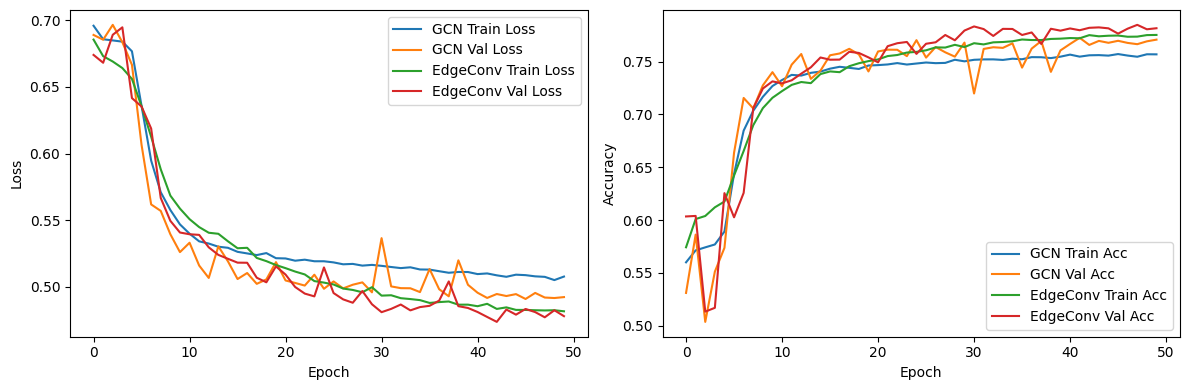

Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.55it/s]


GCN Test Accuracy: 0.7673
EdgeConv Test Accuracy: 0.7768


In [5]:
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_undirected
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Load and Preprocess the Dataset
def load_data(file_path='QG_jets.npz'):
    data = np.load(file_path)
    X = data['X']  # Shape: (100000, M, 4)
    y = data['y']  # Shape: (100000,)
    return X, y

# Step 2: Convert Point-Cloud to Graph (with fix for small jets)
def point_cloud_to_graph(jet, k=3):
    # jet: Shape (M, 4) - [pt, rapidity, azimuthal angle, pdgid]
    # Filter out padded particles (where all features are 0)
    mask = np.sum(jet, axis=1) != 0
    jet = jet[mask]
    
    num_particles = len(jet)
    if num_particles <= 1:  # Skip jets with 0 or 1 particle (can't form a graph)
        return None
    
    # Node features: [pt, rapidity, azimuthal angle, pdgid]
    x = torch.tensor(jet, dtype=torch.float)
    
    # Normalize features (except pdgid)
    scaler = StandardScaler()
    x[:, :3] = torch.tensor(scaler.fit_transform(x[:, :3].numpy()), dtype=torch.float)
    
    # Compute edges using k-NN in (rapidity, azimuthal angle) space
    eta_phi = x[:, 1:3]  # Rapidity and azimuthal angle
    dists = torch.cdist(eta_phi, eta_phi)  # Compute pairwise distances (Delta R approximation)
    
    # Adjust k if the number of particles is less than k + 1
    k_adjusted = min(k, num_particles - 1)  # Ensure we don't select more neighbors than available
    
    # Get k-nearest neighbors (excluding self-loops)
    _, indices = torch.topk(dists, k_adjusted + 1, largest=False)
    indices = indices[:, 1:]  # Exclude the node itself (self-loop)
    
    # Create edge indices
    row = torch.arange(num_particles).repeat_interleave(k_adjusted)
    col = indices.flatten()
    edge_index = torch.stack([row, col], dim=0)
    edge_index = to_undirected(edge_index)  # Make the graph undirected
    
    return Data(x=x, edge_index=edge_index)

# Step 3: Create Dataset
def create_dataset(X, y, k=3):
    dataset = []
    for i in tqdm(range(len(X)), desc="Creating dataset"):
        graph = point_cloud_to_graph(X[i], k=k)
        if graph is not None:
            graph.y = torch.tensor([y[i]], dtype=torch.float)
            dataset.append(graph)
    return dataset

# Step 4: Define GCN Model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, 1)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # GCN layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        
        # Global pooling
        x = global_mean_pool(x, batch)
        
        # Output layer
        x = self.fc(x)
        return torch.sigmoid(x)

# Step 5: Define EdgeConv Model
from torch_geometric.nn import EdgeConv

class EdgeConvModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(EdgeConvModel, self).__init__()
        # Define MLPs for EdgeConv
        self.edge_conv1 = EdgeConv(nn.Sequential(
            nn.Linear(2 * in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        ))
        self.edge_conv2 = EdgeConv(nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        ))
        self.edge_conv3 = EdgeConv(nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        ))
        self.fc = nn.Linear(hidden_channels, 1)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # EdgeConv layers
        x = self.edge_conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.edge_conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.edge_conv3(x, edge_index)
        x = F.relu(x)
        
        # Global pooling
        x = global_mean_pool(x, batch)
        
        # Output layer
        x = self.fc(x)
        return torch.sigmoid(x)

# Step 6: Training Loop with tqdm
def train_model(model, train_loader, val_loader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data).squeeze()
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = (out > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += len(data.y)
        
        train_loss /= len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
                data = data.to(device)
                out = model(data).squeeze()
                loss = criterion(out, data.y)
                val_loss += loss.item()
                pred = (out > 0.5).float()
                correct += (pred == data.y).sum().item()
                total += len(data.y)
        
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accs, val_accs

# Step 7: Main Execution
if __name__ == "__main__":
    # Load data
    X, y = load_data('QG_jets.npz')
    
    # Create dataset with tqdm
    dataset = create_dataset(X, y, k=3)
    
    # Split dataset
    train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)
    
    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]
    test_dataset = [dataset[i] for i in test_idx]
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Train GCN
    print("Training GCN...")
    gcn_model = GCN(in_channels=4, hidden_channels=64).to(device)
    gcn_train_losses, gcn_val_losses, gcn_train_accs, gcn_val_accs = train_model(gcn_model, train_loader, val_loader)
    
    # Train EdgeConv
    print("\nTraining EdgeConv...")
    edgeconv_model = EdgeConvModel(in_channels=4, hidden_channels=64).to(device)
    edgeconv_train_losses, edgeconv_val_losses, edgeconv_train_accs, edgeconv_val_accs = train_model(edgeconv_model, train_loader, val_loader)
    
    # Plotting
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(gcn_train_losses, label='GCN Train Loss')
    plt.plot(gcn_val_losses, label='GCN Val Loss')
    plt.plot(edgeconv_train_losses, label='EdgeConv Train Loss')
    plt.plot(edgeconv_val_losses, label='EdgeConv Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(gcn_train_accs, label='GCN Train Acc')
    plt.plot(gcn_val_accs, label='GCN Val Acc')
    plt.plot(edgeconv_train_accs, label='EdgeConv Train Acc')
    plt.plot(edgeconv_val_accs, label='EdgeConv Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set
    def evaluate(model, loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in tqdm(loader, desc="Evaluating"):
                data = data.to(device)
                out = model(data).squeeze()
                pred = (out > 0.5).float()
                correct += (pred == data.y).sum().item()
                total += len(data.y)
        return correct / total
    
    gcn_test_acc = evaluate(gcn_model, test_loader)
    edgeconv_test_acc = evaluate(edgeconv_model, test_loader)
    
    print(f"\nGCN Test Accuracy: {gcn_test_acc:.4f}")
    print(f"EdgeConv Test Accuracy: {edgeconv_test_acc:.4f}")

Creating dataset: 100%|██████████| 100000/100000 [05:32<00:00, 301.04it/s]


Training GAT...


Epochs:   2%|▏         | 1/50 [01:44<1:25:21, 104.51s/it]

Epoch 1/50, Train Loss: 1.7516, Train Acc: 0.4925, Val Loss: 0.6946, Val Acc: 0.4996


Epochs:   4%|▍         | 2/50 [03:28<1:23:10, 103.96s/it]

Epoch 2/50, Train Loss: 0.6954, Train Acc: 0.4912, Val Loss: 0.6933, Val Acc: 0.5014


Epochs:   6%|▌         | 3/50 [05:15<1:22:31, 105.35s/it]

Epoch 3/50, Train Loss: 0.6944, Train Acc: 0.4905, Val Loss: 0.6924, Val Acc: 0.4880


Epochs:   8%|▊         | 4/50 [07:00<1:20:47, 105.38s/it]

Epoch 4/50, Train Loss: 0.6940, Train Acc: 0.4900, Val Loss: 0.6941, Val Acc: 0.4931


Epochs:  10%|█         | 5/50 [08:43<1:18:19, 104.44s/it]

Epoch 5/50, Train Loss: 0.6942, Train Acc: 0.4922, Val Loss: 0.6941, Val Acc: 0.4925


Epochs:  12%|█▏        | 6/50 [10:22<1:15:11, 102.54s/it]

Epoch 6/50, Train Loss: 0.6942, Train Acc: 0.4868, Val Loss: 0.6945, Val Acc: 0.4925


Epochs:  14%|█▍        | 7/50 [12:10<1:14:51, 104.46s/it]

Epoch 7/50, Train Loss: 0.6939, Train Acc: 0.4944, Val Loss: 0.6923, Val Acc: 0.5161


Epochs:  16%|█▌        | 8/50 [13:58<1:13:47, 105.42s/it]

Epoch 8/50, Train Loss: 0.6939, Train Acc: 0.5039, Val Loss: 0.6924, Val Acc: 0.5153


Epochs:  18%|█▊        | 9/50 [15:56<1:14:53, 109.60s/it]

Epoch 9/50, Train Loss: 0.6936, Train Acc: 0.5022, Val Loss: 0.6931, Val Acc: 0.4560


Epochs:  20%|██        | 10/50 [17:42<1:12:14, 108.37s/it]

Epoch 10/50, Train Loss: 0.6932, Train Acc: 0.5167, Val Loss: 0.6927, Val Acc: 0.5014


Epochs:  22%|██▏       | 11/50 [19:25<1:09:22, 106.72s/it]

Epoch 11/50, Train Loss: 0.6932, Train Acc: 0.5222, Val Loss: 0.6925, Val Acc: 0.5036


Epochs:  24%|██▍       | 12/50 [21:33<1:11:40, 113.17s/it]

Epoch 12/50, Train Loss: 0.6933, Train Acc: 0.5163, Val Loss: 0.6932, Val Acc: 0.4945


Epochs:  26%|██▌       | 13/50 [23:39<1:12:10, 117.05s/it]

Epoch 13/50, Train Loss: 0.6930, Train Acc: 0.5175, Val Loss: 0.6930, Val Acc: 0.5075


Epochs:  28%|██▊       | 14/50 [25:48<1:12:29, 120.83s/it]

Epoch 14/50, Train Loss: 0.6931, Train Acc: 0.5184, Val Loss: 0.6931, Val Acc: 0.4970


Epochs:  30%|███       | 15/50 [27:52<1:10:56, 121.60s/it]

Epoch 15/50, Train Loss: 0.6933, Train Acc: 0.5111, Val Loss: 0.6928, Val Acc: 0.5096


Epochs:  32%|███▏      | 16/50 [30:05<1:10:56, 125.18s/it]

Epoch 16/50, Train Loss: 0.6933, Train Acc: 0.5045, Val Loss: 0.6923, Val Acc: 0.4733


Epochs:  34%|███▍      | 17/50 [32:28<1:11:40, 130.32s/it]

Epoch 17/50, Train Loss: 0.6930, Train Acc: 0.5023, Val Loss: 0.6934, Val Acc: 0.4925


Epochs:  36%|███▌      | 18/50 [34:59<1:12:51, 136.60s/it]

Epoch 18/50, Train Loss: 0.6934, Train Acc: 0.5065, Val Loss: 0.6931, Val Acc: 0.5075


Epochs:  38%|███▊      | 19/50 [37:42<1:14:41, 144.55s/it]

Epoch 19/50, Train Loss: 0.6933, Train Acc: 0.5156, Val Loss: 0.6930, Val Acc: 0.5075


Epochs:  40%|████      | 20/50 [40:48<1:18:27, 156.91s/it]

Epoch 20/50, Train Loss: 0.6933, Train Acc: 0.5065, Val Loss: 0.6930, Val Acc: 0.5075


Epochs:  42%|████▏     | 21/50 [46:17<1:40:52, 208.70s/it]

Epoch 21/50, Train Loss: 0.6929, Train Acc: 0.5169, Val Loss: 0.6930, Val Acc: 0.5010


Epochs:  44%|████▍     | 22/50 [48:44<1:28:43, 190.12s/it]

Epoch 22/50, Train Loss: 0.6931, Train Acc: 0.5251, Val Loss: 0.6926, Val Acc: 0.4844


Epochs:  46%|████▌     | 23/50 [51:40<1:23:42, 186.02s/it]

Epoch 23/50, Train Loss: 0.6927, Train Acc: 0.5253, Val Loss: 0.6927, Val Acc: 0.5050


Epochs:  48%|████▊     | 24/50 [54:54<1:21:39, 188.44s/it]

Epoch 24/50, Train Loss: 0.6919, Train Acc: 0.5559, Val Loss: 0.6927, Val Acc: 0.5002


Epochs:  50%|█████     | 25/50 [57:54<1:17:28, 185.94s/it]

Epoch 25/50, Train Loss: 0.6928, Train Acc: 0.5405, Val Loss: 0.6922, Val Acc: 0.5197


Epochs:  52%|█████▏    | 26/50 [1:00:43<1:12:14, 180.60s/it]

Epoch 26/50, Train Loss: 0.6927, Train Acc: 0.5325, Val Loss: 0.6930, Val Acc: 0.5074


Epochs:  54%|█████▍    | 27/50 [1:03:45<1:09:23, 181.03s/it]

Epoch 27/50, Train Loss: 0.6929, Train Acc: 0.5198, Val Loss: 0.6934, Val Acc: 0.4925


Epochs:  56%|█████▌    | 28/50 [1:06:43<1:06:02, 180.11s/it]

Epoch 28/50, Train Loss: 0.6930, Train Acc: 0.5238, Val Loss: 0.6930, Val Acc: 0.5075


Epochs:  58%|█████▊    | 29/50 [1:09:34<1:02:07, 177.49s/it]

Epoch 29/50, Train Loss: 0.6927, Train Acc: 0.5344, Val Loss: 0.6930, Val Acc: 0.5069


Epochs:  60%|██████    | 30/50 [1:12:36<59:34, 178.72s/it]  

Epoch 30/50, Train Loss: 0.6928, Train Acc: 0.5402, Val Loss: 0.6931, Val Acc: 0.5075


Epochs:  62%|██████▏   | 31/50 [1:15:29<56:05, 177.12s/it]

Epoch 31/50, Train Loss: 0.6924, Train Acc: 0.5435, Val Loss: 0.6934, Val Acc: 0.5075


Epochs:  64%|██████▍   | 32/50 [1:18:30<53:29, 178.33s/it]

Epoch 32/50, Train Loss: 0.6925, Train Acc: 0.5476, Val Loss: 0.6933, Val Acc: 0.5075


Epochs:  66%|██████▌   | 33/50 [1:21:30<50:37, 178.70s/it]

Epoch 33/50, Train Loss: 0.6923, Train Acc: 0.5453, Val Loss: 0.6931, Val Acc: 0.4870


Epochs:  68%|██████▊   | 34/50 [1:24:29<47:42, 178.92s/it]

Epoch 34/50, Train Loss: 0.6921, Train Acc: 0.5473, Val Loss: 0.6925, Val Acc: 0.5067


Epochs:  70%|███████   | 35/50 [1:27:40<45:36, 182.42s/it]

Epoch 35/50, Train Loss: 0.6910, Train Acc: 0.5579, Val Loss: 0.6930, Val Acc: 0.5075


Epochs:  72%|███████▏  | 36/50 [1:31:55<47:39, 204.23s/it]

Epoch 36/50, Train Loss: 0.6909, Train Acc: 0.5615, Val Loss: 0.6929, Val Acc: 0.5031


Epochs:  74%|███████▍  | 37/50 [1:32:56<34:55, 161.18s/it]

Epoch 37/50, Train Loss: 0.6908, Train Acc: 0.5619, Val Loss: 0.6921, Val Acc: 0.5011


Epochs:  76%|███████▌  | 38/50 [1:33:53<25:59, 129.95s/it]

Epoch 38/50, Train Loss: 0.6905, Train Acc: 0.5618, Val Loss: 0.6910, Val Acc: 0.5060


Epochs:  78%|███████▊  | 39/50 [1:34:49<19:47, 107.95s/it]

Epoch 39/50, Train Loss: 0.6903, Train Acc: 0.5626, Val Loss: 0.6923, Val Acc: 0.5036


Epochs:  80%|████████  | 40/50 [1:35:46<15:26, 92.61s/it] 

Epoch 40/50, Train Loss: 0.6902, Train Acc: 0.5577, Val Loss: 0.6919, Val Acc: 0.5016


Epochs:  82%|████████▏ | 41/50 [1:36:40<12:10, 81.14s/it]

Epoch 41/50, Train Loss: 0.6913, Train Acc: 0.5529, Val Loss: 0.6929, Val Acc: 0.5072


Epochs:  84%|████████▍ | 42/50 [1:37:38<09:51, 74.00s/it]

Epoch 42/50, Train Loss: 0.6910, Train Acc: 0.5540, Val Loss: 0.6936, Val Acc: 0.5067


Epochs:  86%|████████▌ | 43/50 [1:38:35<08:03, 69.07s/it]

Epoch 43/50, Train Loss: 0.6914, Train Acc: 0.5531, Val Loss: 0.6930, Val Acc: 0.5075


Epochs:  88%|████████▊ | 44/50 [1:41:12<09:32, 95.33s/it]

Epoch 44/50, Train Loss: 0.6910, Train Acc: 0.5555, Val Loss: 0.6932, Val Acc: 0.5075


Epochs:  90%|█████████ | 45/50 [1:43:23<08:49, 105.93s/it]

Epoch 45/50, Train Loss: 0.6911, Train Acc: 0.5544, Val Loss: 0.6924, Val Acc: 0.5066


Epochs:  92%|█████████▏| 46/50 [1:44:17<06:01, 90.39s/it] 

Epoch 46/50, Train Loss: 0.6897, Train Acc: 0.5662, Val Loss: 0.6948, Val Acc: 0.5075


Epochs:  94%|█████████▍| 47/50 [1:45:11<03:58, 79.60s/it]

Epoch 47/50, Train Loss: 0.6892, Train Acc: 0.5653, Val Loss: 0.6954, Val Acc: 0.5075


Epochs:  96%|█████████▌| 48/50 [1:46:07<02:24, 72.42s/it]

Epoch 48/50, Train Loss: 0.6896, Train Acc: 0.5604, Val Loss: 0.6949, Val Acc: 0.5072


Epochs:  98%|█████████▊| 49/50 [1:47:02<01:07, 67.12s/it]

Epoch 49/50, Train Loss: 0.6887, Train Acc: 0.5633, Val Loss: 0.6888, Val Acc: 0.5316


Epochs: 100%|██████████| 50/50 [1:47:55<00:00, 129.50s/it]


Epoch 50/50, Train Loss: 0.6886, Train Acc: 0.5671, Val Loss: 0.6905, Val Acc: 0.4983


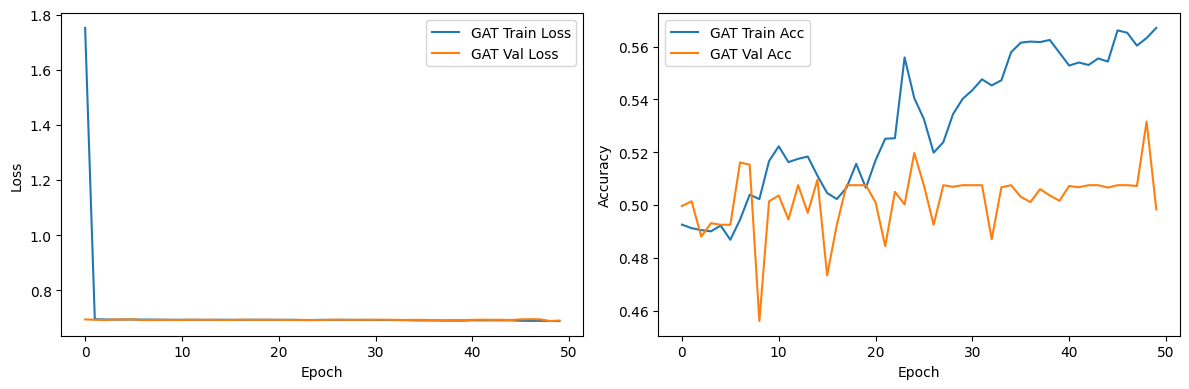

Evaluating: 100%|██████████| 79/79 [00:02<00:00, 30.71it/s]


GAT Test Accuracy: 0.4939


In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Load and Preprocess the Dataset
def load_data(file_path='QG_jets.npz'):
    data = np.load(file_path)
    X = data['X']  # Shape: (100000, M, 4)
    y = data['y']  # Shape: (100000,)
    return X, y

# Step 2: Convert Point-Cloud to Graph
def point_cloud_to_graph(jet, k=3):
    # jet: Shape (M, 4) - [pt, rapidity, azimuthal angle, pdgid]
    # Filter out padded particles (where all features are 0)
    mask = np.sum(jet, axis=1) != 0
    jet = jet[mask]
    
    num_particles = len(jet)
    if num_particles <= 1:  # Skip jets with 0 or 1 particle (can't form a graph)
        return None
    
    # Node features: [pt, rapidity, azimuthal angle, pdgid]
    x = torch.tensor(jet, dtype=torch.float)
    
    # Normalize features (except pdgid)
    scaler = StandardScaler()
    x[:, :3] = torch.tensor(scaler.fit_transform(x[:, :3].numpy()), dtype=torch.float)
    
    # Compute edges using k-NN in (rapidity, azimuthal angle) space
    eta_phi = x[:, 1:3]  # Rapidity and azimuthal angle
    dists = torch.cdist(eta_phi, eta_phi)  # Compute pairwise distances (Delta R approximation)
    
    # Adjust k if the number of particles is less than k + 1
    k_adjusted = min(k, num_particles - 1)  # Ensure we don't select more neighbors than available
    
    # Get k-nearest neighbors (excluding self-loops)
    _, indices = torch.topk(dists, k_adjusted + 1, largest=False)
    indices = indices[:, 1:]  # Exclude the node itself (self-loop)
    
    # Create edge indices
    row = torch.arange(num_particles).repeat_interleave(k_adjusted)
    col = indices.flatten()
    edge_index = torch.stack([row, col], dim=0)
    edge_index = to_undirected(edge_index)  # Make the graph undirected
    
    return Data(x=x, edge_index=edge_index)

# Step 3: Create Dataset
def create_dataset(X, y, k=3):
    dataset = []
    for i in tqdm(range(len(X)), desc="Creating dataset"):
        graph = point_cloud_to_graph(X[i], k=k)
        if graph is not None:
            graph.y = torch.tensor([y[i]], dtype=torch.float)
            dataset.append(graph)
    return dataset

# Step 4: Define GAT Model
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_heads=4):
        super(GAT, self).__init__()
        # GAT layers with multi-head attention
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=0.3)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=0.3)
        self.conv3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, dropout=0.3)
        self.fc = nn.Linear(hidden_channels, 1)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # GAT layers
        x = F.elu(self.conv1(x, edge_index))  # ELU activation as recommended in GAT paper
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.elu(self.conv3(x, edge_index))
        
        # Global pooling
        x = global_mean_pool(x, batch)
        
        # Output layer
        x = self.fc(x)
        return torch.sigmoid(x)

# Step 5: Training Loop with tqdm
def train_model(model, train_loader, val_loader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data).squeeze()
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = (out > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += len(data.y)
        
        train_loss /= len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
                data = data.to(device)
                out = model(data).squeeze()
                loss = criterion(out, data.y)
                val_loss += loss.item()
                pred = (out > 0.5).float()
                correct += (pred == data.y).sum().item()
                total += len(data.y)
        
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accs, val_accs

# Step 6: Main Execution
if __name__ == "__main__":
    # Load data
    X, y = load_data('QG_jets.npz')
    
    # Create dataset with tqdm
    dataset = create_dataset(X, y, k=3)
    
    # Split dataset
    train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)
    
    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]
    test_dataset = [dataset[i] for i in test_idx]
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Train GAT
    print("Training GAT...")
    gat_model = GAT(in_channels=4, hidden_channels=16, num_heads=4).to(device)  # hidden_channels * num_heads = 64
    gat_train_losses, gat_val_losses, gat_train_accs, gat_val_accs = train_model(gat_model, train_loader, val_loader)
    
    # Plotting
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(gat_train_losses, label='GAT Train Loss')
    plt.plot(gat_val_losses, label='GAT Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(gat_train_accs, label='GAT Train Acc')
    plt.plot(gat_val_accs, label='GAT Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set
    def evaluate(model, loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in tqdm(loader, desc="Evaluating"):
                data = data.to(device)
                out = model(data).squeeze()
                pred = (out > 0.5).float()
                correct += (pred == data.y).sum().item()
                total += len(data.y)
        return correct / total
    
    gat_test_acc = evaluate(gat_model, test_loader)
    
    print(f"\nGAT Test Accuracy: {gat_test_acc:.4f}")